<a href="https://colab.research.google.com/github/jiseungkyu/jsk/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.7 MB/s eta 0:00:00


In [5]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

100%|██████████| 9912422/9912422 [00:00<00:00, 159619267.03it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40231050.76it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45897872.29it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7324309.41it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch 1
-------------------------------
loss: 0.090207, acc: 0.085938 [    0/60000]
loss: 0.090051, acc: 0.109375 [12800/60000]
loss: 0.089850, acc: 0.164062 [25600/60000]
loss: 0.089415, acc: 0.203125 [38400/60000]
loss: 0.089013, acc: 0.210938 [51200/60000]
val 정확률= 19.996045529842377 

Epoch 2
-------------------------------
loss: 0.088935, acc: 0.234375 [    0/60000]
loss: 0.089019, acc: 0.210938 [12800/60000]
loss: 0.088652, acc: 0.195312 [25600/60000]
loss: 0.088151, acc: 0.281250 [38400/60000]
loss: 0.087714, acc: 0.296875 [51200/60000]
val 정확률= 28.214004635810852 

Epoch 3
-------------------------------
loss: 0.087483, acc: 0.375000 [    0/60000]
loss: 0.087889, acc: 0.265625 [12800/60000]
loss: 0.087336, acc: 0.335938 [25600/60000]
loss: 0.086709, acc: 0.421875 [38400/60000]
loss: 0.086247, acc: 0.390625 [51200/60000]
val 정확률= 38.42959105968475 

Epoch 4
-------------------------------
loss: 0.085807, acc:

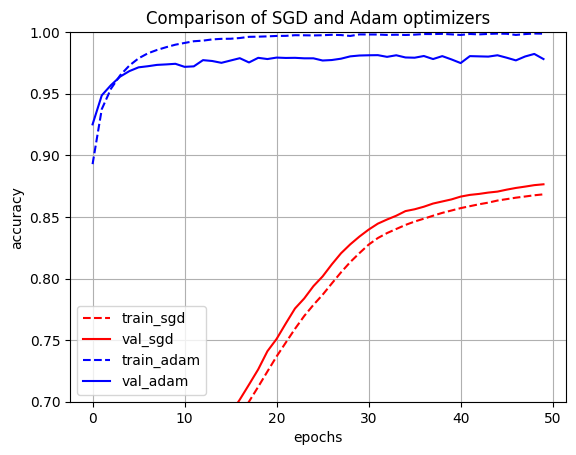

In [6]:
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = nn.Flatten() # 다차원 입력을 1차원으로 펼침
        self.model = nn.Sequential(
            nn.Linear(784, 512), # 784개의 입력을 받아 512개의 출력을 생성
            nn.Tanh(), # Tanh 활성화 함수 사용
            nn.Linear(512, 10), # 512개의 입력을 받아 10개의 출력을 생성
            nn.Softmax(dim=1), # Softmax 함수를 사용하여 출력을 확률 분포로 변환
        )

    def forward(self, x):
        x = self.reshape(x) # 입력을 1차원으로 펼침
        x = self.model(x) # 펼쳐진 x를 순차적으로 정의된 레이어에 통과
        return x


# 모델 학습
def training_epoch(dataloader, device, model, loss_fn, optimizer, metric):
    size = len(dataloader.dataset) # 데이터셋의 크기를 저장
    acc_list = [] # 리스트 초기화
    model.train() # 학습 모드로 설정
    for batch, (x, y) in enumerate(dataloader): # 데이터로더로부터 배치를 가져옴
        x = x.to(device) # x 전송
        y = y.to(device) # y 전송
        y_onehot = F.one_hot(y, num_classes=10).float() # 정답 레이블을 원핫 인코딩으로 변환

        y_hat = model(x) # 모델에 입력을 전달
        loss = loss_fn(y_hat, y_onehot) # 예측과 실제 레이블 간의 손실 계산
        acc = metric(y_hat, y) # 정확도 계산
        acc_list.append(acc) # 정확도를 리스트에 추가

        optimizer.zero_grad() # 이전 배치의 그래디언트 초기화
        loss.backward() # 현재 배치의 손실에 대한 그래디언트 계산
        optimizer.step() # 옵티마이저를 사용해 파라이터 업데이트

        # 매 배치마다 현재 손실과 정확도 출력
        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(x)
            print(f"loss: {loss:>7f}, acc: {acc:>7f} [{current:>5d}/{size:>5d}]")

    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 현재 에포크에서의 평균 정확도 계산
    return mean_acc # 정확도 반환


# 검증 함수
def validation(dataloader, device, model, metric):
    acc_list = []
    model.eval()
    with torch.no_grad(): # 그래디언트 계산 필요 없음
        for x, y in dataloader: # 검증 데이터에서 배치 가져오기
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x) # 모델에 입력 전달해 예측을 얻음
            acc = metric(y_hat, y) # 현재 배치에서의 정확도 계산
            acc_list.append(acc) # 정확도를 리스트에 추가

    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 평균 정확도 계산
    return mean_acc


# 테스트 함수
def test(dataloader, device, model, metric):
    return validation(dataloader, device, model, metric)


# 데이터 준비
train_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
train_loader = DataLoader(train_data, batch_size=128)
test_loader = DataLoader(test_data, batch_size=128)


# 모델 학습
device = "cuda" if torch.cuda.is_available() else "cpu"  # gpu사용
model_sgd = SequentialModel().to(device)
loss_fn = nn.MSELoss() # MSE 사용
optimizer = optim.SGD(model_sgd.parameters(), lr=0.01) # SGD 옵티마이저 정의, 학습률 0.01
metric = Accuracy(task="multiclass", num_classes=10).to(device)

hist_sgd = defaultdict(list)  # defaultdict를 사용하여 빈 리스트를 가진 딕셔너리 생성
max_epochs = 50 # 학습 에포크 수 설정
# 에포크를 반복하면서 모델을 훈련
for t in range(max_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # 훈련 데이터에 대한 에포크 진행 및 정확도 및 손실 기록
    train_acc = training_epoch(train_loader, device, model_sgd, loss_fn, optimizer, metric)
    # 검증 데이터에 대한 에포크 진행 및 정확도 기록
    val_acc = validation(test_loader, device, model_sgd, metric)

    print("val 정확률=", val_acc * 100, "\n") # 검증 정확도 출력

     # 훈련 및 검증 정확도를 딕셔너리에 추가
    hist_sgd["accuracy"].append(train_acc)
    hist_sgd["val_accuracy"].append(val_acc)

torch.save(model_sgd.state_dict(), "mnist-sgd.pth") # SGD 옵티마이저를 사용한 모델 저장

# 새로운 모델 생성 및 저장된 상태 불러오기
model_sgd = SequentialModel().to(device)
model_sgd.load_state_dict(torch.load("mnist-sgd.pth"))

# 테스트 데이터에 대한 정확도 계산
test_acc = test(test_loader, device, model_sgd, metric)
print("SGD 정확률=", test_acc * 100)

# 새로운 모델과 Adam 옵티마이저 생성 및 저장된 상태 불러오기
model_adam = SequentialModel().to(device)
optimizer = optim.Adam(model_adam.parameters(), lr=0.001)

# Adam 옵티마이저를 사용한 모델의 학습 및 검증 정확도 기록
hist_adam = defaultdict(list)
max_epochs = 50
for t in range(max_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc = training_epoch(train_loader, device, model_adam, loss_fn, optimizer, metric)
    val_acc = validation(test_loader, device, model_adam, metric)
    print("val 정확률=", val_acc * 100, "\n")
    hist_adam["accuracy"].append(train_acc)
    hist_adam["val_accuracy"].append(val_acc)

torch.save(model_adam.state_dict(), "mnist-adam.pth") # Adam 옵티마이저를 사용한 모델 저장

# 새로운 모델과 Adam 옵티마이저 생성 및 저장된 상태 불러오기
model_adam = SequentialModel().to(device)
model_adam.load_state_dict(torch.load("mnist-adam.pth"))

print("Adam 정확률=", test(test_loader, device, model_adam, metric) * 100)

plt.plot(hist_sgd["accuracy"], "r--")
plt.plot(hist_sgd["val_accuracy"], "r")
plt.plot(hist_adam["accuracy"], "b--")
plt.plot(hist_adam["val_accuracy"], "b")
plt.title("Comparison of SGD and Adam optimizers")
plt.ylim((0.7, 1.0))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train_sgd", "val_sgd", "train_adam", "val_adam"])
plt.grid()
plt.show()

Epoch 1
-------------------------------
loss: 2.304063, acc: 0.093750 [    0/60000]
loss: 0.501973, acc: 0.867188 [12800/60000]
loss: 0.328155, acc: 0.890625 [25600/60000]
loss: 0.291956, acc: 0.937500 [38400/60000]
loss: 0.341337, acc: 0.890625 [51200/60000]
val 정확률= 91.94027185440063 

Epoch 2
-------------------------------
loss: 0.207282, acc: 0.945312 [    0/60000]
loss: 0.177295, acc: 0.968750 [12800/60000]
loss: 0.221136, acc: 0.921875 [25600/60000]
loss: 0.186656, acc: 0.953125 [38400/60000]
loss: 0.205802, acc: 0.937500 [51200/60000]
val 정확률= 94.35324668884277 

Epoch 3
-------------------------------
loss: 0.129560, acc: 0.976562 [    0/60000]
loss: 0.120018, acc: 0.976562 [12800/60000]
loss: 0.189130, acc: 0.921875 [25600/60000]
loss: 0.143186, acc: 0.968750 [38400/60000]
loss: 0.157264, acc: 0.953125 [51200/60000]
val 정확률= 95.52017450332642 

Epoch 4
-------------------------------
loss: 0.095646, acc: 0.976562 [    0/60000]
loss: 0.089216, acc: 0.976562 [12800/60000]
loss:

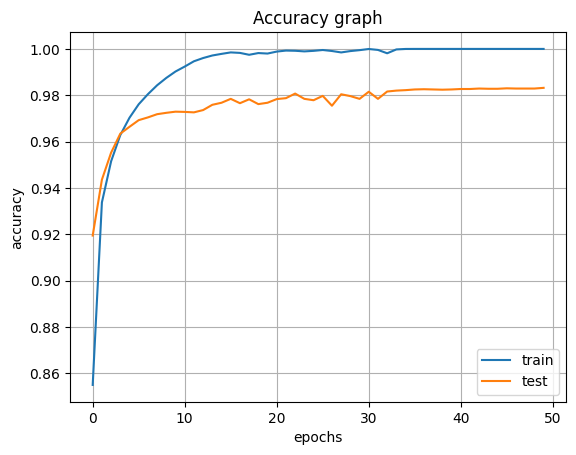

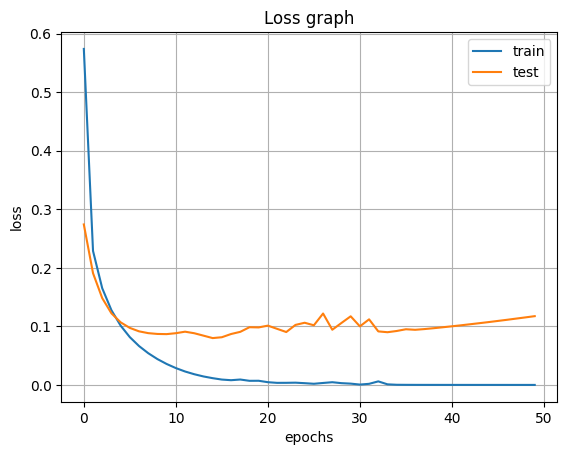

In [7]:
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = nn.Flatten() # 다차원 입력을 1차원으로 펼침
        self.model = nn.Sequential(
            nn.Linear(784, 1024), # 784개의 입력을 받아 1024개의 출력을 생성
            nn.ReLU(),
            nn.Linear(1024, 512), # 1024개의 입력을 받아 512개의 출력을 생성
            nn.ReLU(),
            nn.Linear(512, 512), # 512개의 입력을 받아 512개의 출력을 생성
            nn.ReLU(),
            nn.Linear(512, 10), # 512개의 입력을 받아 10개의 출력을 생성
        )

    def forward(self, x):
        x = self.reshape(x) # 입력을 1차원으로 펼침
        x = self.model(x) # 펼쳐진 x를 순차적으로 정의된 레이어에 통과
        return x


# 모델 학
def training_epoch(dataloader, device, model, loss_fn, optimizer, metric):
    size = len(dataloader.dataset) # 데이터셋의 크기를 저장
    num_batches = len(dataloader) # 배치의 총 개수 저장
    total_loss = 0 # 손실 초기화
    acc_list = [] # 리스트 초기화
    model.train() # 학습 모드로 설정

    for batch, (x, y) in enumerate(dataloader): # 데이터로더로부터 배치를 가져옴
        x = x.to(device) # x 전송
        y = y.to(device) # Y 전송

        y_hat = model(x) # 모델에 입력을 전달
        loss = loss_fn(y_hat, y) # 예측과 실제 레이블 간의 손실 계산
        total_loss += loss.item() # 현재 배치의 손실을 누적
        acc = metric(y_hat, y) # 정확도 계산
        acc_list.append(acc) # 정확도를 리스트에 추가

        optimizer.zero_grad() # 이전 배치의 그래디언트 초기화
        loss.backward() # 현재 배치의 손실에 대한 그래디언트 계산
        optimizer.step() # 옵티마이저를 사용해 파라이터 업데이트

        # 매 배치마다 현재 손실과 정확도 출력
        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(x)
            print(f"loss: {loss:>7f}, acc: {acc:>7f} [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 현재 에포크에서의 평균 정확도 계산
    return total_loss, mean_acc # 정확도와 손실 리스트 반환


# 검증 데이터 손실 계산
def validation(dataloader, device, model, loss_fn, metric):
    num_batches = len(dataloader) # 현 에포크에서 사용되는 배치의 총 개수 저장
    total_loss = 0 # 현 에포크에서 사용되는 배치의 총 개수 저장실 초기화
    acc_list = [] # 정확도 초기화
    model.eval() # 평가 모드로 설정
    with torch.no_grad(): # 평가에서는 그래디언트 계산 필요 없음
        for x, y in dataloader:
            x = x.to(device) # x 전송
            y = y.to(device) # y 전송

            y_hat = model(x) # 입력 후 예측
            loss = loss_fn(y_hat, y) # 손실 계산
            total_loss += loss.item() # 손실 누적
            acc = metric(y_hat, y) # 정확도 계산
            acc_list.append(acc) # 정확도 추가

    total_loss /= num_batches # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 평균 정확도 계산
    return total_loss, mean_acc # 평균 손실,정확도 반환


def test(dataloader, device, model, loss_fn, metric):
    _, mean_acc = validation(dataloader, device, model, loss_fn, metric)
    return mean_acc


train_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
train_loader = DataLoader(train_data, batch_size=128)
test_loader = DataLoader(test_data, batch_size=128)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SequentialModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
metric = Accuracy(task="multiclass", num_classes=10).to(device)

max_epochs = 50
history = defaultdict(list)
for t in range(max_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = training_epoch(train_loader, device, model, loss_fn, optimizer, metric)
    val_loss, val_acc = validation(test_loader, device, model, loss_fn, metric)
    print("val 정확률=", val_acc * 100, "\n")
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

torch.save(model.state_dict(), "dmlp_trained.pth")

model = SequentialModel().to(device)
model.load_state_dict(torch.load("dmlp_trained.pth"))

print("정확률=", test(test_loader, device, model, loss_fn, metric) * 100)

plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Accuracy graph")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "test"])
plt.grid()
plt.show()

plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "test"])
plt.grid()
plt.show()